In [1]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread
np.random.seed(1234)

## SGD dynamics

In [3]:
#Ground truth data distribution
def random_sample_anisotropic(d, Delta, N, s_0):
    y = np.random.randint(0,2,N)
    y = np.where(y == 0, -1, y)
    x = np.zeros((N,d))
    for i in range(N):
        if y[i] == 1:
            x[i,:] = np.random.multivariate_normal([0]*d, np.diag([(1+Delta)**2]*s_0 + [1]*(d-s_0)))
        if y[i] == -1:
            x[i,:] = np.random.multivariate_normal([0]*d, np.diag([(1-Delta)**2]*s_0 + [1]*(d-s_0)))
    return x.reshape(N,d),y

In [259]:
#Relu activation function

def neural_net_relu(a,b,w,x):
    #shape of w: (N,d)
    #shape of x: (n,d)
    #shape of b: (1,N)
    #shape of a: (1,N)
    n = x.shape[0]
    return np.mean(a.T*np.max(w@x.T+b.T, 0), axis = 0).reshape(1,n)

def relu(a,b,w,x):
    #shape of w: (N,d)
    #shape of x: (n,d)
    #shape of b: (1,N)
    #shape of a: (1,N)
    N = w.shape[0]
    n = x.shape[0]
    return (a.T*np.maximum(w@x.T+b.T, 0)).reshape(N,n)

def drelu(t):
    if t>0:
        return 1
    else:
        return 0
drelu = np.vectorize(drelu)

def grad_sigma_relu(a,b,w,x):
    #shape of w: (N,d)
    #shape of x: (n,d)
    #shape of b: (1,N)
    #shape of a; (1,N)
    N = w.shape[0]
    d = w.shape[1]
    
    da = relu(a,b,w,x).reshape(1,N)
    db = a*drelu(w@x.T+b.T).reshape(1,N)
    dw = ((a.T*drelu(w@x.T+b.T))*x).reshape(N,d)
    
    return da, db, dw

In [260]:
def stochastic_gradient_descent(d, s_0, Delta, N, epsilon = 1e-5, num_epochs = 1000):
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), N).reshape(N, d)
    a = np.ones(N).reshape(1,N)
    b = np.ones(N).reshape(1,N)
    indices = [int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 60))]
    risk = []
    steps = epsilon*(epsilon*np.arange(1,num_epochs+1))**(-0.25)
    mean_dist = []
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        da, db, dw = grad_sigma_relu(a,b,weights,x)
        
        weights += 2*steps[epoch-1]*(y-neural_net_relu(a, b, weights, x))*dw
        a += 2*steps[epoch-1]*(y-neural_net_relu(a, b, weights, x))*da
        b += 2*steps[epoch-1]*(y-neural_net_relu(a, b, weights, x))*db
        
        if epoch in indices:
        #population risk
            M = int(5e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample-neural_net_relu(a, b,weights, x_sample))**2)
            risk.append(mse)
            #dist = np.mean(np.linalg.norm(weights, axis = 1))
            #mean_dist.append(dist)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
                
    return weights, np.array(risk)#, mean_dist, indices

In [262]:
weights, risk = stochastic_gradient_descent(32, 6, 0.6, 80, epsilon = 2e-4, num_epochs = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 12, risk: 8.272775692155122
Epoch: 13, risk: 7.952919990116441
Epoch: 14, risk: 7.830043762862834
Epoch: 15, risk: 7.9035007679466025
Epoch: 16, risk: 7.7715136934311815
Epoch: 18, risk: 7.731284792980671
Epoch: 19, risk: 7.8191545604500625
Epoch: 21, risk: 7.579670933237301
Epoch: 22, risk: 7.492326769728609
Epoch: 24, risk: 7.2782178466035
Epoch: 26, risk: 7.135721876003641
Epoch: 28, risk: 7.1620475960815035
Epoch: 30, risk: 7.024534541592543
Epoch: 33, risk: 6.928178092081714
Epoch: 35, risk: 6.88189392694357
Epoch: 38, risk: 6.717153896431383
Epoch: 41, risk: 6.41964593591711
Epoch: 44, risk: 6.483351434149741
Epoch: 47, risk: 6.309162047438254
Epoch: 51, risk: 6.125351291890054
Epoch: 55, risk: 5.902670373307567
Epoch: 59, risk: 5.900707766030129
Epoch: 64, risk: 5.65806876386294
Epoch: 69, risk: 5.491880406836498
Epoch: 74, risk: 5.278644689975358
Epoch: 80, risk: 5.172468674775187
Epoch: 86, risk: 4.965448776547713
Epoch: 93, risk: 4.892807594904576
Epoch: 100, risk: 4.6

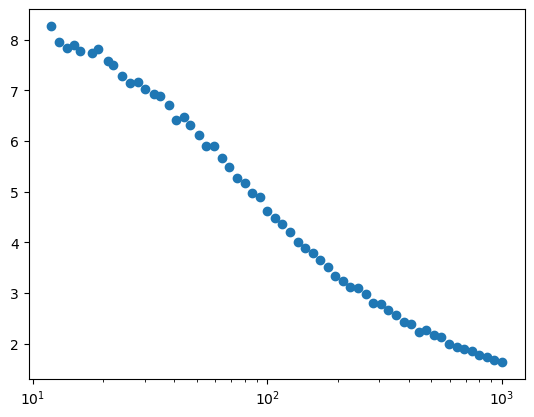

In [265]:
indices = [int(a) for a in 10**(np.linspace(1.1, 3, 60))]
plt.scatter(indices, risk)
plt.xscale('log')

## PDE simulation

In [137]:
from scipy.stats import norm

def q_plus(r1, r2, b, Delta):
    root_plus = np.sqrt((1+Delta)**2*r1**2+r2**2)
    return b*norm.cdf(b/(root_plus))+root_plus*norm.pdf(b/root_plus)

def q_minus(r1, r2, b, Delta):
    root_minus = np.sqrt((1-Delta)**2*r1**2+r2**2)
    return b*norm.cdf(b/(root_minus))+root_minus*norm.pdf(b/root_minus)


def dq_minus(r1, r2, b, Delta):
    root_minus = np.sqrt((1-Delta)**2*r1**2+r2**2)
    return b*norm.cdf(b/(root_minus))+root_minus*norm.pdf(b/root_minus)

def dq_plus(r1, r2, b, Delta):
    from scipy.stats import norm
    d_normal = lambda x: -x*norm.pdf(x)
    
    root_plus = np.sqrt((1+Delta)**2*r1**2+r2**2)
    
    droot_plus_1 = (1+Delta)**2*r1/root_plus
    droot_plus_2 = r2/root_plus
    
    db = norm.cdf(b/(root_plus)) + b/(root_plus)*norm.pdf(b/root_plus) + d_normal(b/root_plus)
    dr1 = -droot_plus_1/(root_plus**2)*b**2*norm.pdf(b/(root_plus))\
                    +droot_plus_1*norm.pdf(b/root_plus) -b*droot_plus_1/(root_plus**2)*d_normal(b/root_plus)
    dr2 = -droot_plus_2/(root_plus**2)*b**2*norm.pdf(b/(root_plus))\
                    +droot_plus_2*norm.pdf(b/root_plus) -b*droot_plus_2/(root_plus**2)*d_normal(b/root_plus)
    return db, dr1, dr2


def dq_minus(r1, r2, b, Delta):
    from scipy.stats import norm
    d_normal = lambda x: -x*norm.pdf(x)
    
    root_minus = np.sqrt((1-Delta)**2*r1**2+r2**2)
    
    droot_minus_1 = (1-Delta)**2*r1/root_minus
    droot_minus_2 = r2/root_minus
    
    db = norm.cdf(b/(root_minus)) + b/(root_minus)*norm.pdf(b/root_minus) + d_normal(b/root_minus)
    dr1 = -droot_minus_1/(root_minus**2)*b**2*norm.pdf(b/(root_minus))\
                    +droot_minus_1*norm.pdf(b/root_minus) -b*droot_minus_1/(root_minus**2)*d_normal(b/root_minus)
    dr2 = -droot_minus_2/(root_minus**2)*b**2*norm.pdf(b/(root_minus))\
                    +droot_minus_2*norm.pdf(b/root_minus) -b*droot_minus_2/(root_minus**2)*d_normal(b/root_minus)
    return db, dr1, dr2


def R_inf(r, Delta):
    #shape of r is (J, 4)
    a = r[:,0]
    b = r[:,1]
    r1 = r[:,2]
    r2 = r[:,3]
    
    plus = a*q_plus(r1, r2, b, Delta)
    minus = a*q_minus(r1, r2, b, Delta)

    mean_q_plus = np.mean(plus)
    mean_q_minus = np.mean(minus)
    return 0.5 * (1 - mean_q_plus) ** 2 + 0.5 * (1 + mean_q_minus) ** 2

def grad_R_inf(r, Delta):
    
    #shape of r: (J, 4)
    #shape of grad: (J, 4)
    
    J = len(r)
    
    #shape of r is (J, 4)
    a = r[:,0]
    b = r[:,1]
    r1 = r[:,2]
    r2 = r[:,3]
    
    plus = a*q_plus(r1, r2, b, Delta)
    minus = a*q_minus(r1, r2, b, Delta)

    mean_q_plus = np.mean(plus)
    mean_q_minus = np.mean(minus)
    
    db_plus, dr1_plus, dr2_plus = dq_plus(r1, r2, b, Delta)
    db_minus, dr1_minus, dr2_minus = dq_minus(r1, r2, b, Delta)
    
    grad = np.zeros((J,4))
    #da
    grad[:,0] = -1/J*plus*mean_q_plus + 1/J*minus*mean_q_minus
    #db
    grad[:,1] = -1/J*db_plus*mean_q_plus + 1/J*db_minus*mean_q_minus
    #dr1
    grad[:,2] = -1/J*dr1_plus*mean_q_plus + 1/J*dr1_minus*mean_q_minus
    #dr2
    grad[:,3] = -1/J*dr2_plus*mean_q_plus + 1/J*dr2_minus*mean_q_minus
    
    return grad

def update(r, dt, grad):
    J = len(r)
    return J * grad * dt

In [148]:
#simulate pde
def pde_sim(d = 320, J=1, epsilon = 2e-4, Delta = 0.2, s_0 = 60):
    Interval = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e4))
    risk = []
    separations = [Interval[k+1]-Interval[k] for k in range(len(Interval)-1)]
    #initialise params
    Z = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), J).reshape(J, d)
    a = np.ones(J)
    b = np.ones(J)
    r1 = np.linalg.norm(Z[:,:s_0], axis = 1)
    r2 = np.linalg.norm(Z[:,s_0:], axis = 1)
    r = np.vstack((a,b,r1,r2)).reshape(J,4)
    
    for k in trange(len(separations)):
        dt = separations[k]
        grad = grad_R_inf(r, Delta)
        r = r + (Interval[k])**(-0.25)*update(r,dt, grad)
        error = R_inf(r, Delta)
        risk.append(error)
        print(error)
    return risk

In [ ]:
risk = pde_sim(d = 320, J = 400, epsilon = 2e-4, Delta = 0.6, s_0 = 60)

  0%|          | 0/9999 [00:00<?, ?it/s]

1.4950250449144884
1.4950250448706348
1.4950250448266809
1.4950250447826259
1.4950250447384696
1.4950250446942117
1.4950250446498519
1.49502504460539
1.4950250445608257
1.4950250445161595
1.4950250444713902
1.495025044426518
1.495025044381542
1.495025044336464
1.495025044291281
1.495025044245994
1.495025044200604
1.4950250441551096
1.495025044109509
1.495025044063805
1.4950250440179953
1.49502504397208
1.4950250439260593
1.4950250438799335
1.4950250438337007
1.4950250437873622
1.4950250437409165
1.4950250436943648
1.4950250436477057
1.4950250436009387
1.4950250435540648
1.4950250435070829
1.4950250434599928
1.495025043412794
1.495025043365488
1.4950250433180714
1.4950250432705474
1.4950250432229133
1.4950250431751704
1.4950250431273167
1.4950250430793526
1.49502504303128
1.4950250429830954
1.4950250429347995
1.4950250428863938
1.4950250428378762
1.4950250427892475
1.4950250427405058
1.4950250426916531
1.4950250426426872
1.4950250425936102
1.4950250425444187
1.4950250424951153
1.4950250

1.495025011105351
1.4950250109837404
1.495025010861851
1.4950250107396812
1.4950250106172307
1.4950250104944978
1.495025010371483
1.4950250102481848
1.4950250101246039
1.4950250100007378
1.495025009876588
1.4950250097521516
1.4950250096274293
1.49502500950242
1.4950250093771247
1.495025009251539
1.4950250091256658
1.495025008999502
1.4950250088730497
1.4950250087463048
1.4950250086192705
1.4950250084919425
1.4950250083643217
1.4950250082364078
1.4950250081082
1.4950250079796965
1.495025007850898
1.4950250077218028
1.4950250075924119
1.495025007462722
1.4950250073327347
1.495025007202448
1.4950250070718623
1.495025006940976
1.495025006809788
1.4950250066782986
1.4950250065465074
1.4950250064144122
1.4950250062820134
1.4950250061493107
1.4950250060163022
1.4950250058829884
1.4950250057493673
1.4950250056154395
1.4950250054812035
1.4950250053466585
1.4950250052118044
1.49502500507664
1.495025004941165
1.4950250048053777
1.495025004669278
1.4950250045328661
1.49502500439614
1.4950250042591

1.4950249163345553
1.495024915994984
1.4950249156546325
1.495024915313497
1.4950249149715777
1.4950249146288725
1.4950249142853782
1.4950249139410945
1.4950249135960192
1.4950249132501499
1.4950249129034845
1.4950249125560224
1.4950249122077615
1.4950249118586996
1.4950249115088343
1.4950249111581644
1.4950249108066886
1.4950249104544042
1.4950249101013091
1.4950249097474033
1.495024909392682
1.4950249090371457
1.495024908680791
1.4950249083236176
1.4950249079656224
1.4950249076068034
1.4950249072471602
1.4950249068866894
1.49502490652539
1.4950249061632581
1.4950249058002947
1.4950249054364964
1.4950249050718605
1.4950249047063873
1.4950249043400723
1.4950249039729155
1.4950249036049146
1.495024903236067
1.4950249028663705
1.495024902495825
1.4950249021244266
1.4950249017521737
1.495024901379065
1.4950249010050989
1.4950249006302718
1.4950249002545826
1.4950248998780298
1.4950248995006108
1.4950248991223238
1.4950248987431667
1.4950248983631376
1.495024897982235
1.495024897600456
1.49

1.4950245972560328
1.4950245961826216
1.4950245951067413
1.4950245940283873
1.4950245929475525
1.4950245918642322
1.4950245907784205
1.4950245896901113
1.4950245885992997
1.495024587505979
1.495024586410144
1.495024585311789
1.495024584210907
1.4950245831074938
1.495024582001543
1.4950245808930478
1.495024579782004
1.4950245786684058
1.4950245775522444
1.4950245764335173
1.4950245753122164
1.4950245741883377
1.4950245730618739
1.495024571932819
1.4950245708011671
1.4950245696669138
1.4950245685300507
1.4950245673905735
1.4950245662484758
1.4950245651037508
1.4950245639563937
1.4950245628063978
1.4950245616537567
1.4950245604984642
1.4950245593405158
1.4950245581799035
1.4950245570166225
1.4950245558506656
1.4950245546820276
1.4950245535107014
1.4950245523366819
1.4950245511599616
1.4950245499805355
1.4950245487983966
1.4950245476135393
1.4950245464259566
1.4950245452356428
1.4950245440425916
1.4950245428467956
1.4950245416482508
1.495024540446948
1.495024539242884
1.4950245380360498
1.

1.4950236287402991
1.4950236254394311
1.495023622130972
1.4950236188149035
1.4950236154912087
1.4950236121598703
1.49502360882087
1.4950236054741908
1.495023602119814
1.495023598757723
1.4950235953878999
1.4950235920103256
1.4950235886249839
1.495023585231857
1.4950235818309252
1.4950235784221737
1.4950235750055807
1.4950235715811302
1.4950235681488053
1.4950235647085852
1.4950235612604534
1.4950235578043918
1.4950235543403811
1.495023550868404
1.4950235473884415
1.495023543900476
1.495023540404489
1.4950235369004612
1.495023533388375
1.495023529868211
1.495023526339951
1.4950235228035769
1.4950235192590693
1.4950235157064105
1.495023512145581
1.4950235085765617
1.4950235049993335
1.4950235014138795
1.4950234978201793
1.4950234942182137
1.4950234906079631
1.4950234869894108
1.495023483362536
1.4950234797273196
1.495023476083743
1.4950234724317863
1.4950234687714314
1.4950234651026575
1.4950234614254467
1.495023457739778
1.4950234540456333
1.4950234503429922
1.495023446631835
1.49502344

1.4950206807654307
1.4950206706846818
1.495020660580748
1.495020650453578
1.4950206403031165
1.4950206301293105
1.4950206199321077
1.4950206097114525
1.4950205994672907
1.49502058919957
1.4950205789082354
1.4950205685932318
1.4950205582545062
1.4950205478920024
1.4950205375056678
1.4950205270954462
1.4950205166612824
1.495020506203122
1.49502049572091
1.4950204852145912
1.4950204746841085
1.4950204641294078
1.495020453550434
1.4950204429471299
1.49502043231944
1.4950204216673075
1.4950204109906786
1.4950204002894947
1.4950203895636989
1.4950203788132368
1.49502036803805
1.4950203572380831
1.4950203464132776
1.495020335563577
1.4950203246889235
1.4950203137892606
1.49502030286453
1.4950202919146756
1.4950202809396376
1.4950202699393587
1.4950202589137818
1.4950202478628478
1.4950202367864986
1.4950202256846759
1.495020214557321
1.4950202034043747
1.495020192225779
1.4950201810214745
1.4950201697914018
1.4950201585355027
1.4950201472537163
1.4950201359459834
1.4950201246122456
1.49502011

1.4950111447831906
1.4950111127718506
1.495011080686893
1.4950110485281498
1.4950110162954497
1.495010983988625
1.4950109516075027
1.495010919151913
1.4950108866216845
1.495010854016647
1.4950108213366264
1.495010788581451
1.495010755750948
1.4950107228449436
1.4950106898632654
1.4950106568057393
1.49501062367219
1.4950105904624433
1.4950105571763235
1.4950105238136553
1.4950104903742618
1.4950104568579685
1.495010423264597
1.4950103895939706
1.4950103558459118
1.495010322020241
1.4950102881167822
1.4950102541353543
1.4950102200757804
1.4950101859378786
1.4950101517214696
1.4950101174263732
1.495010083052408
1.4950100485993927
1.4950100140671458
1.4950099794554843
1.4950099447642267
1.4950099099931893
1.4950098751421892
1.4950098402110414
1.4950098051995628
1.4950097701075677
1.4950097349348723
1.4950096996812898
1.4950096643466333
1.4950096289307193
1.4950095934333592
1.495009557854365
1.4950095221935502
1.4950094864507266
1.4950094506257046
1.4950094147182964
1.4950093787283107
1.495

1.4949813696174177
1.4949812691366364
1.494981168424812
1.4949810674814132
1.4949809663059075
1.4949808648977618
1.4949807632564405
1.4949806613814074
1.4949805592721266
1.4949804569280578
1.4949803543486637
1.4949802515334012
1.4949801484817284
1.4949800451931023
1.4949799416669778
1.494979837902809
1.4949797339000492
1.4949796296581495
1.4949795251765599
1.49497942045473
1.494979315492107
1.4949792102881372
1.4949791048422667
1.4949789991539388
1.4949788932225958
1.4949787870476798
1.4949786806286298
1.4949785739648864
1.4949784670558852
1.494978359901063
1.4949782524998554
1.4949781448516954
1.494978036956015
1.494977928812246
1.4949778204198176
1.4949777117781582
1.4949776028866948
1.4949774937448534
1.4949773843520575
1.4949772747077321
1.4949771648112982
1.4949770546621755
1.4949769442597831
1.4949768336035392
1.4949767226928603
1.4949766115271617
1.4949765001058581
1.49497638842836
1.4949762764940786
1.494976164302425
1.4949760518528068
1.4949759391446305
1.4949758261773027
1.49

1.4949022366223812
1.4949019542205422
1.4949016711696104
1.4949013874680928
1.4949011031144956
1.4949008181073224
1.4949005324450704
1.4949002461262357
1.49489995914931
1.4948996715127811
1.4948993832151334
1.4948990942548506
1.4948988046304081
1.4948985143402809
1.4948982233829418
1.4948979317568558
1.494897639460488
1.4948973464922979
1.4948970528507435
1.4948967585342776
1.4948964635413498
1.4948961678704071
1.4948958715198906
1.4948955744882408
1.4948952767738923
1.4948949783752776
1.4948946792908246
1.494894379518958
1.494894079058099
1.494893777906665
1.4948934760630703
1.494893173525724
1.4948928702930335
1.4948925663634018
1.4948922617352274
1.4948919564069063
1.4948916503768306
1.4948913436433884
1.494891036204963
1.4948907280599364
1.4948904192066863
1.4948901096435838
1.4948897993690007
1.4948894883813024
1.49488917667885
1.4948888642600033
1.4948885511231147
1.4948882372665377
1.494887922688618
1.4948876073876987
1.4948872913621194
1.4948869746102158
1.4948866571303192
1.49

1.4946603653055592
1.4946595273014849
1.494658687373591
1.4946578455174715
1.4946570017287049
1.4946561560028653
1.4946553083355116
1.4946544587221966
1.4946536071584606
1.4946527536398337
1.4946518981618375
1.4946510407199827
1.4946501813097683
1.4946493199266842
1.4946484565662104
1.494647591223815
1.4946467238949586
1.4946458545750891
1.4946449832596431
1.4946441099440506
1.4946432346237266
1.4946423572940795
1.4946414779505057
1.49464059658839
1.4946397132031084
1.4946388277900242
1.4946379403444938
1.4946370508618587
1.494636159337453
1.4946352657665996
1.4946343701446076
1.4946334724667805
1.4946325727284067
1.4946316709247662
1.4946307670511272
1.4946298611027486
1.4946289530748766
1.4946280429627485
1.4946271307615873
1.4946262164666084
1.4946253000730176
1.4946243815760039
1.4946234609707507
1.4946225382524285
1.4946216134161971
1.4946206864572047
1.494619757370588
1.494618826151474
1.4946178927949785
1.4946169572962056
1.4946160196502465
1.494615079852184
1.4946141378970899
1

1.493945951121089
1.493943475932751
1.4939409950822813
1.4939385085567958
1.4939360163433841
1.4939335184291047
1.4939310148009906
1.493928505446041
1.4939259903512285
1.4939234695034957
1.493920942889757
1.4939184104968957
1.4939158723117663
1.493913328321194
1.4939107785119745
1.4939082228708729
1.493905661384625
1.4939030940399374
1.4939005208234857
1.4938979417219154
1.4938953567218445
1.4938927658098575
1.4938901689725117
1.4938875661963322
1.4938849574678132
1.4938823427734218
1.4938797220995914
1.493877095432727
1.4938744627592009
1.4938718240653566
1.4938691793375072
1.493866528561934
1.4938638717248862
1.4938612088125864
1.493858539811221
1.4938558647069495
1.4938531834858977
1.4938504961341608
1.4938478026378041
1.4938451029828606
1.493842397155331
1.4938396851411864
1.4938369669263656
1.4938342424967763
1.493831511838292
1.4938287749367591
1.493826031777987
1.4938232823477586
1.4938205266318212
1.4938177646158894
1.4938149962856495
1.4938122216267522
1.4938094406248186
1.493

1.491717404266469
1.491709859487197
1.4917022976412049
1.491694718690541
1.4916871225971737
1.4916795093229849
1.4916718788297805
1.49166423107928
1.4916565660331236
1.491648883652868
1.4916411838999883
1.491633466735876
1.4916257321218407
1.49161798001911
1.4916102103888265
1.4916024231920497
1.4915946183897584
1.4915867959428444
1.4915789558121195
1.4915710979583086
1.4915632223420534
1.491555328923912
1.4915474176643582
1.49153948852378
1.4915315414624835
1.4915235764406862
1.491515593418524
1.4915075923560455
1.4914995732132155
1.4914915359499108
1.4914834805259254
1.491475406900966
1.491467315034654
1.4914592048865243
1.4914510764160247
1.4914429295825165
1.4914347643452763
1.4914265806634925
1.4914183784962656
1.4914101578026113
1.4914019185414544
1.4913936606716363
1.4913853841519067
1.4913770889409321
1.4913687749972846
1.4913604422794546
1.491352090745841
1.4913437203547542
1.4913353310644148
1.4913269228329575
1.4913184956184249
1.4913100493787737
1.4913015840718675
1.4912930

In [172]:
epsilon = 2e-4
Interval = 10**np.linspace(-10, np.log10(epsilon*1e7), int(1e4))

discretised_pde_1 = lambda k: risk[np.abs(Interval - epsilon**(4/4)*k).argmin()]
disc_pde_loss_1 = np.vectorize(discretised_pde_1)
iters = np.arange(1, int(1e6)+1)

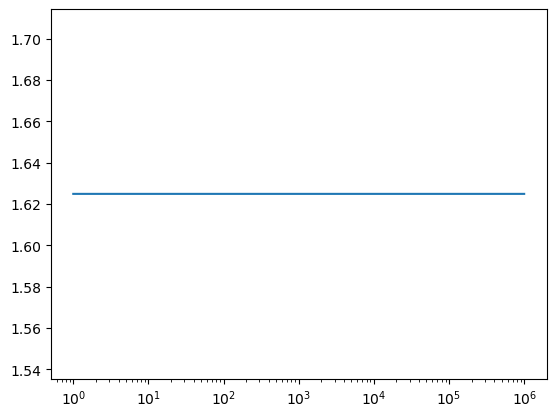

In [173]:
plt.plot(iters, disc_pde_loss_1(iters))
plt.xscale('log')

In [191]:
J = 400
d = 320
s_0 = 60
Delta = 0.6
Z = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), J).reshape(J, d)
a = np.ones(J)
b = np.ones(J)
r1 = np.linalg.norm(Z[:,:s_0], axis = 1)
r2 = np.linalg.norm(Z[:,s_0:], axis = 1)
r = np.vstack((a,b,r1,r2)).reshape(J,4)
R_inf(r, Delta)

1.498479900978055